Text(0.5, 1.0, 'Average')

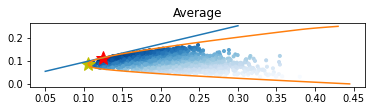

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

rf=0.015
data_1=pd.read_csv('./business_cycle_label.csv')
data_1_np=data_1.to_numpy()
data_2=pd.read_csv('./midterm_data.csv')


df=pd.DataFrame(columns=range(8)).reset_index(drop=True)
df_up=pd.DataFrame(columns=range(8)).reset_index(drop=True) 
df_down=pd.DataFrame(columns=range(8)).reset_index(drop=True)
# df.columns=df_up.columns=df_down.columns=data_2.columns

for i in range(0,data_1.shape[0]):
    entry=data_2.loc[i]
    if data_1_np[i][1]==1:
        df_up=pd.concat([df_up,entry],axis=1,ignore_index=True)
    else:
        df_down=pd.concat([df_down,entry],axis=1,ignore_index=True)
    df=pd.concat([df,entry],axis=1,ignore_index=True)

# (1) business_cycle_label.csv를 이용해 midterm_data.csv로 다음의 세 가지 pandas dataframe들을 생성하시오 (5점)
df_up=df_up.transpose().drop(columns='Unnamed: 0').dropna().reset_index(drop=True).astype("float64")
df=df.transpose().drop(columns='Unnamed: 0').dropna().reset_index(drop=True).astype("float64")
df_down=df_down.transpose().drop(columns='Unnamed: 0').dropna().reset_index(drop=True).astype("float64") 


# (2) (1)에서 생성한 각 dataframe에 대해, 무위험자산을 배제하고 자산의 가중치들을 무작위로 부여한 random portfolio를 5,000개 생성해 이를 ( 𝜇,𝜎 ) 공간에 표시하시오. (10점)
# (3) 모든 dataframe에 대해 무위험자산을 포함한 efficient frontier를 도출한 다음 이를 하나의 ( 𝜇,𝜎 ) 공간에 표시하고, 서로의 annualized Sharpe Ratio를 비교하시오. (10점)

def ret_std(weight,ret):
    port_mean=np.sum(weight*ret.mean()*252)
    port_var=np.dot(weight.T,np.dot(ret.cov()*252,weight))
    port_std=np.sqrt(port_var)
    return port_mean,port_std


ret=df
ret_down=df_down
ret_up=df_up
noa=len(ret.columns)
ret_arr=[ret,ret_up,ret_down]
color_arr=['Blues','Greens','Oranges']
title=["Average","Boom","Recession"]


def statistics(ret,weight,rf=0):
    weight=np.array(weight)
    pret=np.sum(ret.mean()*weight)*252-rf
    pvol=np.sqrt(np.dot(weight.T,np.dot(ret.cov()*252,weight)))
    return np.array([pret,pvol,pret/pvol])

def min_func_port(weight,ret):
    return statistics(ret,weight)[1]

def min_func_sharpe(weight,ret,rf=0.015):
    return -statistics(ret,weight,rf)[2]

def min_func_volatility(weight,ret):
    return statistics(ret,weight)[1]**2

cons=({'type':'eq','fun':lambda x : np.sum(x)-1})
bnds=tuple((0,1) for x in range(noa))

# slope=( (statistics(opts['x'])[0]-rf)/statistics(opts['x'])[1] )
# var_list=[x*slope+rf for x in np.linspace(0.16,0.30,2500)]

x=np.linspace(0.05,0.3,1500)

i=0
ret=ret_arr[i]
port_rets=[]
port_std=[]
opts=opt.minimize(min_func_sharpe,noa*[1./noa,],ret,method='SLSQP',bounds=bnds,constraints=cons)
optv=opt.minimize(min_func_volatility,noa*[1./noa],ret,method='SLSQP',bounds=bnds,constraints=cons)
slope=( (statistics(ret,opts['x'])[0]-rf)/statistics(ret,opts['x'])[1] )
y=[x*slope+rf for x in np.linspace(0.05,0.3,1500)]
trets=np.linspace(0.0,0.25,100)
tvols=[]
for tret in trets:
    cons_temp = ({'type': 'eq', 'fun': lambda x:  statistics(ret,x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,],ret, method='SLSQP' ,
            bounds=bnds, constraints=cons_temp)
    tvols.append(res['fun'])
tvols=np.array(tvols)
for w in range(5000):
    weight=np.random.random(noa)
    weight/=np.sum(weight)
    mu,sig=ret_std(weight,ret)
    port_rets.append(mu)
    port_std.append(sig)
sr=np.array(port_rets)/np.array(port_std)
plt.subplot(3,1,i+1)
plt.scatter(port_std,port_rets,c=sr,marker='.',cmap=color_arr[i])
plt.plot(statistics(ret,opts['x'])[1],statistics(ret,opts['x'])[0],'r*',markersize=15.0,label='Portfolio with highest Sharpe Ratio')
plt.plot(statistics(ret,optv['x'])[1],statistics(ret,optv['x'])[0],'y*',markersize=15.0,label='Minimum Variance portfolio')
plt.plot(x,y,label='mean-variance frontier with riskfree asset')
plt.plot(tvols,np.linspace(0.0,0.25,100))
plt.title(title[i])

Text(0.5, 1.0, 'Boom')

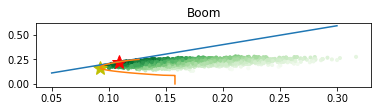

In [2]:
i=1
ret=ret_arr[i]
port_rets=[]
port_std=[]
opts=opt.minimize(min_func_sharpe,noa*[1./noa,],ret,method='SLSQP',bounds=bnds,constraints=cons)
optv=opt.minimize(min_func_volatility,noa*[1./noa],ret,method='SLSQP',bounds=bnds,constraints=cons)
slope=( (statistics(ret,opts['x'])[0]-rf)/statistics(ret,opts['x'])[1] )
y=[x*slope+rf for x in np.linspace(0.05,0.3,1500)]
trets=np.linspace(0.0,0.25,100)
tvols=[]
for tret in trets:
    cons_temp = ({'type': 'eq', 'fun': lambda x:  statistics(ret,x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,],ret, method='SLSQP' ,
            bounds=bnds, constraints=cons_temp)
    tvols.append(res['fun'])
tvols=np.array(tvols)
for w in range(5000):
    weight=np.random.random(noa)
    weight/=np.sum(weight)
    mu,sig=ret_std(weight,ret)
    port_rets.append(mu)
    port_std.append(sig)
sr=np.array(port_rets)/np.array(port_std)
plt.subplot(3,1,i+1)
plt.scatter(port_std,port_rets,c=sr,marker='.',cmap=color_arr[i])
plt.plot(statistics(ret,opts['x'])[1],statistics(ret,opts['x'])[0],'r*',markersize=15.0,label='Portfolio with highest Sharpe Ratio')
plt.plot(statistics(ret,optv['x'])[1],statistics(ret,optv['x'])[0],'y*',markersize=15.0,label='Minimum Variance portfolio')
plt.plot(x,y,label='mean-variance frontier with riskfree asset')
plt.plot(tvols,np.linspace(0.0,0.25,100))
plt.title(title[i])

Text(0.5, 1.0, 'Recession')

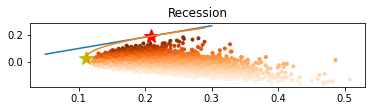

In [3]:
i=2
ret=ret_arr[i]
port_rets=[]
port_std=[]
opts=opt.minimize(min_func_sharpe,noa*[1./noa,],ret,method='SLSQP',bounds=bnds,constraints=cons)
optv=opt.minimize(min_func_volatility,noa*[1./noa],ret,method='SLSQP',bounds=bnds,constraints=cons)
slope=( (statistics(ret,opts['x'])[0]-rf)/statistics(ret,opts['x'])[1] )
y=[x*slope+rf for x in np.linspace(0.05,0.3,1500)]
trets=np.linspace(0.0,0.25,100)
tvols=[]
for tret in trets:
    cons_temp = ({'type': 'eq', 'fun': lambda x:  statistics(ret,x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,],ret, method='SLSQP' ,
            bounds=bnds, constraints=cons_temp)
    tvols.append(res['fun'])
tvols=np.array(tvols)
for w in range(5000):
    weight=np.random.random(noa)
    weight/=np.sum(weight)
    mu,sig=ret_std(weight,ret)
    port_rets.append(mu)
    port_std.append(sig)
sr=np.array(port_rets)/np.array(port_std)
plt.subplot(3,1,i+1)
plt.scatter(port_std,port_rets,c=sr,marker='.',cmap=color_arr[i])
plt.plot(statistics(ret,opts['x'])[1],statistics(ret,opts['x'])[0],'r*',markersize=15.0,label='Portfolio with highest Sharpe Ratio')
plt.plot(statistics(ret,optv['x'])[1],statistics(ret,optv['x'])[0],'y*',markersize=15.0,label='Minimum Variance portfolio')
plt.plot(x,y,label='mean-variance frontier with riskfree asset')
plt.plot(tvols,np.linspace(0.0,0.25,100))
plt.title(title[i])

# (4) (3)번의 결과를 고려할 때, 경기 순환을 고려한 포트폴리오 운용이 실효성이 있는가? 그 근거는 무엇인가?  (10점)
# (sigma,return) (0.12,0.1)->0.79 ,(0.1,0.2-0.015)->1.92, (0.21,0.18-0.015)->0.83
# It is meaningful because slope of CML is change by business fluctiation
# (5) 경기 순환의 국면별 tangency portfolio를 고려할 때, 경기가 확장/후퇴 할때 어떤 자산을 보유하고 있는게 좋은가? (5점)
# Boom -> high sharpe portfolio(slope)
# Recession -> low sharpe portfolio(slope)
